In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [95]:
import pydicom
import numpy as np
import torch
import os
from pathlib import Path
import matplotlib.pyplot as plt
import zipfile
from scipy import ndimage

# Extract

In [24]:
#  
download_dir = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/Download/'
for idx in range(1, 21):
    path_to_zip_file = download_dir + f'3Dircadb1.{idx}/PATIENT_DICOM.zip'
    directory_to_extract_to = download_dir + f'3Dircadb1.{idx}/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

# Convert

In [135]:
def zoom_data(data, voxel_size, is_label, factor=1.0, zoom_func=ndimage.zoom, **kwargs):
    '''
    :param 
        - data: volume or label
        - voxel_size: real distance of voxel - (depth, height, width)
        - factor: rate of size out with size in of volume - (a float number) 
        - order: type of spline interpolation
        - zoom_func: zoom function: defautl is scipy.ndimage.zoom()
        - karg: a dict of options to pass to zoom_func.
    '''
    if is_label:
        data[data>0] = 255

    # compute factor size
    zoom_factor = voxel_size[0] / factor , voxel_size[1] / factor, voxel_size[2] / factor

    # zoom data
    vol_out = zoom_func(data, zoom_factor, **kwargs)

    # Make width and height is a even number
    if vol_out.shape[1] % 2 == 1:
        vol_out = vol_out[:, 0:-1, :]
    if vol_out.shape[2] % 2 == 1:
        vol_out = vol_out[:, :, 0:-1]

    if is_label:
        vol_out[vol_out <= 100] = 0
        vol_out[vol_out > 100] = 1
        
    return vol_out

def read_all_slice(path):
    n_slices = int(len(os.listdir(path)))
    volume = np.zeros((n_slices, 512, 512), dtype=np.float32)
    for idx in range(0, n_slices):
        image_path = path + f'image_{idx}'
        image = pydicom.dcmread(image_path)
        image_arr = image.pixel_array
        volume[idx] = image_arr
    spacing =  float(image.SliceThickness), float(image.PixelSpacing[0]), float(image.PixelSpacing[1])
    return volume, spacing

def merge_tumor(path, size):
    tumor_dir_names = [dir for dir in os.listdir(path) if 'livertumor' in dir]
    print(tumor_dir_names)
    n_tumors = len(tumor_dir_names)
    init_tumor = np.zeros(size, dtype=np.uint8)

    for idx in range(n_tumors):
        tumor_path = path + tumor_dir_names[idx] + '/'
        tumor, _ = read_all_slice(tumor_path)
        tumor = np.clip(tumor, 0, 1).astype(np.uint8)
        init_tumor = init_tumor + tumor
    
    return np.clip(init_tumor, 0, 1)

In [ ]:
save_dir = 'Zoom_only_10'
save_vol_dir = f'/content/drive/My Drive/Tumor_src/Datasets/3Dircad/{save_dir}/VOLUME'
save_mask_dir = f'/content/drive/My Drive/Tumor_src/Datasets/3Dircad/{save_dir}/LIVER'

save_vol_dir = Path(save_vol_dir)
save_mask_dir = Path(save_mask_dir)

save_vol_dir.mkdir(parents=True, exist_ok=True)
save_mask_dir.mkdir(parents=True, exist_ok=True)

save_vol_dir = str(save_vol_dir)
save_mask_dir = str(save_mask_dir)

In [ ]:
zoom_spacing = 1.0

for idx in range(1, 21)
    # Read the dicom image
    patient_path = f'/content/drive/My Drive/Tumor_src/Datasets/3Dircad/Download/3Dircadb1.{idx}/'

    patient, _ = read_all_slice(patient_path + 'PATIENT_DICOM/')

    liver, spacing = read_all_slice(patient_path + 'MASKS_DICOM/liver/')

    tumor = merge_tumor(patient_path + 'MASKS_DICOM/', liver.shape)

    #Zoom factor
    zoom_volume = zoom_data(patient, spacing, False, factor=zoom_spacing, zoom_func=ndimage.zoom, order=3)
    liver = zoom_data(liver, spacing, True, factor=zoom_spacing, zoom_func=ndimage.zoom, order=1)
    tumor = zoom_data(tumor, spacing, True, factor=zoom_spacing, zoom_func=ndimage.zoom, order=1)

    liver = np.clip(liver, 0, 1)
    tumor = np.clip(tumor, 0, 1)
    zoom_mask = liver + tumor
    zoom_mask = np.clip(zoom_mask, 0, 1)

    # save as pth file
    vol_name = f'/volume_{idx}.pth'
    torch.save(torch.from_numpy(zoom_volume).to(torch.float32), save_vol_dir + vol_name)
    torch.save(torch.from_numpy(zoom_mask).to(torch.float32), save_mask_dir + vol_name)
    print(f'Save vol_{idx}')
print('Done!')



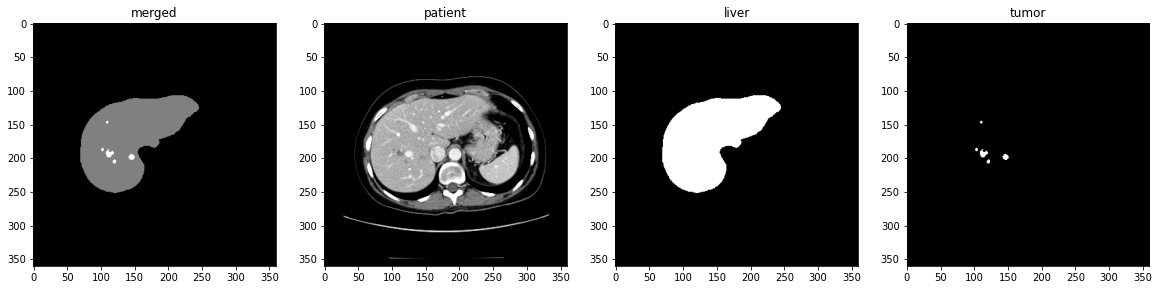

In [134]:
slice_idx = 230
fig = plt.figure(figsize=(20, 5))
fig.add_subplot(1, 4, 1)
plt.title('merged')
plt.imshow(merged[slice_idx], cmap='gray')
fig.add_subplot(1, 4, 2)
plt.title('patient')
plt.imshow(patient[slice_idx], cmap='gray')
fig.add_subplot(1, 4, 3)
plt.title('liver')
plt.imshow(liver[slice_idx], cmap='gray')
fig.add_subplot(1, 4, 4)
plt.title('tumor')
plt.imshow(tumor[slice_idx], cmap='gray')

In [ ]:


for idx in range(131):
    vol_path = f'/content/drive/My Drive/Tumor_src/Datasets/LITS17/volume/volume-{idx}.nii'
    seg_path = f'/content/drive/My Drive/Tumor_src/Datasets/LITS17/segmentation/segmentation-{idx}.nii'
    # Read the .nii image containing the volume with SimpleITK:
    volume = sitk.ReadImage(vol_path)
    seg = sitk.ReadImage(seg_path)
    spacing = seg.GetSpacing() # order h, w, d

    # and access the numpy array:
    vol_data = sitk.GetArrayFromImage(volume).astype(np.float32)
    seg_data = sitk.GetArrayFromImage(seg).astype(np.float32)
    
    # process
    seg_data[seg_data > 1] = 1 # merge tumor to liver

    # zoom factor
    zoom_volume = zoom_data(vol_data, spacing, False, factor=zoom_spacing, zoom_func=ndimage.zoom, order=3)
    zoom_mask = zoom_data(seg_data, spacing, True, factor=zoom_spacing, zoom_func=ndimage.zoom, order=1)

    # save as pth file
    vol_name = f'/volume_{idx}.pth'
    torch.save(torch.from_numpy(zoom_volume).to(torch.float32), save_vol_dir + vol_name)
    torch.save(torch.from_numpy(zoom_mask).to(torch.float32), save_mask_dir + vol_name)
    print(f'Save vol_{idx}')
print('Done!')